# Lumberton Testbed

NC Buildings and Infrastructure Flood Damage Analysis

## 1. Background

Lumberton is a small culturally diverse city with a population of 21,542 according to the most recent United States census estimates. This population mainly settled on the banks of the Lumber River and most of the households are low-medium income with an average $31,899 gross annual income with 39.0% White, 36.7% African American, 12.7% Native American (the Lumbee Tribe), and 6.7% Hispanic/Latino. The below figure shows the physical boundaries of Lumberton with respect to the location of the state of North Carolina and Robeson County.  Buildings locations within the city are shown by the dots of various colors in addition to other collected physical infrastructure. This testbed was created to:

1. Laverage the on-going Lumberton longitudinal field study and provide numerical support with models and insightful predections. 
2. Investigate the impact of flooding on buildings and infrastructure.
3. Evaluate a number of mitigation strategies and their impacts on flood damage/loss at the building- and community-level.
4. Evaluate hybrid metrics of community resilience, such as those that require coupled modeling between social and physical systems.

More information about the testbed and the field study can be found in these publications:
1. van de Lindt, J. W., Peacock, W. G., Mitrani-Reiser, J., Rosenheim, N., Deniz, D., Dillard, M. K., Tomiczek, T., Koliou, M., Graettinger, A., Crawford, S., Harrison, K. W., Barbosa, A., Tobin, J., Helgeson, J. F., Peek, L., Memari, M., Sutley, E., Hamideh, S., Gu, D., Cauffman, S. A., and Fung, J. F. (2018). The Lumberton, North Carolina Flood of 2016: A Community Resilience Focused Technical Investigation. https://doi.org/10.6028/NIST.SP.1230
2. Van De Lindt, John W., Walter Gillis Peacock, Judith Mitrani-Reiser, Nathanael Rosenheim, Derya Deniz, Maria Dillard, Tori Tomiczek et al. "Community resilience-focused technical investigation of the 2016 Lumberton, North Carolina, flood: An interdisciplinary approach." Natural Hazards Review 21, no. 3 (2020): 04020029.https://doi.org/10.1061/(ASCE)NH.1527-6996.0000387


![image2020-8-4_15-25-21.png](images/image2020-8-4_15-25-21.png)

The current notebook is a **WORK-IN-PROGRESS** that consists of the following modules:
1. Flood Hazard Modeling for inland communities.
2. Flood Damage Analysis for Buildings.
3. Household Unit Allocation Modeling.
4. Population Dislocation analysis based on Hurricane Matthew in 2016.

The models used in this testbed come from:
1. Omar M. Nofal, and John W van de Lindt. 2020. “Probabilistic Flood Loss Assessment at the Community Scale: A Case Study of 2016 Flooding in Lumberton, NC.” Journal of Risk and Uncertainty in Engineering Systems, Part A: Civil Engineering, 6(2):1-15 https://doi.org/10.1061/AJRUA6.0001060
2. Omar M. Nofal, John W van de Lindt, and Trung Q. Do. 2020. “Multi-Variate and Single-Variable Flood Fragility and Loss Approaches for Buildings.” Journal of Reliability Engineering and System Safety, 12(8), 2277 https://doi.org/10.1016/j.ress.2020.106971
3. Omar M. Nofal, and John W van de Lindt. 2020. “Minimal Building Flood Fragility and Loss Function Portfolio for Resilience Analysis at the Community-Level.”  Water, 12(8), 2277 https://doi.org/10.3390/w12082277
4. Omar M. Nofal, and John W van de Lindt. 2020. “High-Resolution Approach to Quantify the Impact of Building-Level Flood Risk Mitigation and Adaptation Measures on Flood Losses at the Community-Level.” International Journal of Disaster Risk Reduction. https://doi.org/10.1016/j.ijdrr.2020.101903
5. Omar M. Nofal, and John W van de Lindt. 2021. “High-Resolution Flood Risk Approach to Quantify the Impact of Policy Change on Flood Losses at Community-Level.” International Journal of Disaster Risk Reduction. https://doi.org/10.1016/j.ijdrr.2021.102429
6. Rosenheim, Nathanael, Roberto Guidotti, Paolo Gardoni & Walter Gillis Peacock. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. https://doi.org/10.1080/23789689.2019.1681821

**Note**: The building inventory used for building damage analysis has a smaller geographic boundary when compared to the housing unit inventory. This is because the building inventory used for the damage analysis above includes the buildings that are exposed to modeled flood hazard for the primary study area (Lumberton, NC). However, the housing unit inventory used for the household allocation includes all of Robeson County. 

The differences between the building inventory and the housing unit inventory is the reason for the missing (NaN) damage state values in the table at the end of the chapters 3 and 4 where the address points are associated with the buildings outside the building inventory footprint. While these address points are outside of the modeled hazard boundary, which explains that all DSs are equal to NaN, they are important for further socio-economic analysis such as identifying the indirect flood impacts on the population outside the study area.

# Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**.

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>1.3.0 | see: https://tools.in-core.org/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.5.0 | see: https://tools.in-core.org/doc/pyincore_viz/index.html |
| matplotlib | 3.1.2 | used for plotting results |

## 2. Building Damage Analysis
The following code is preparing the IN-CORE analysis by checking versions and connecting to IN-CORE web service.

In [1]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability

import os
import pandas as pd
import numpy as np
import geopandas as gpd # For reading in shapefiles
import matplotlib.pyplot as plt
from IPython.display import display

import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore_viz.geoutil import GeoUtil as viz
from pyincore_viz.plotutil import PlotUtil as plot

client = IncoreClient()
client.clear_cache()

Connection successful to IN-CORE services. pyIncore version detected: 1.13.0


In [2]:
# create data_service object for loading files
data_service = DataService(client)

In [3]:
# Check package versions - good practice for replication
print("Python Version ",sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:52:10) 
[Clang 15.0.7 ]
pandas version:  2.1.4
numpy version:  1.26.3


### 2.1 Flood Hazard Modeling
Hydrologic and hydrodynamic models were developed to model the flood hazard. The hydrologic analysis was conducted on HEC-HMS using the morphological data (e.g., land use, soil data), precipitation data (measured by National Weather Service), basin characteristics (a high-resolution Digital Elevation Map (DEM)), and data calibration (using the measured stream hydrograph). The hydrodynamic analysis was conducted on HEC-RAS using a high-resolution DEM (1.5m pixel size) provided by NOAA and the hydrographs (discharge-time relationship) provided by USGS. A smaller than usual mesh size (20m x 20m) was used to model the 2-D flow area to ensure the effect of levees and other hydraulic structures can be accurately accounted for in the models. A scenario-based hazard model was used based on the rainfall event after the 2016 Hurricane Matthew. A raster map of the developed flood hazard and the evolution of the flooding event are shown in the below figure. The hazard data are available in terms of scenario-based with the following IDs in IN-CORE:

* The flooding event after hurricane Matthew in 2016 ID: 5f5916456f515f55ee30a5f0
* The flood depth measured from ground elevation ID: 5f59163b96a72270bcb81c58
* The Water Surface Elevation (WSE) ID: 5f59163f96a72270bcb81c5c


![image2020-8-4_16-20-45.png](images/image2020-8-4_16-20-45.png)

The following code reads the flood hazard data 

In [4]:
# Flood Inundation Hazard Map based on the flooding event after Hurricane Matthew in 2016 from IN-CORE
hazard_type = "flood"
Flood_Inundation_Depth_ft_id = "5f59163b96a72270bcb81c58"   # Raster Map for the flood inundation depth in ft

#visualize the Flood Inundation hazard data 
Flood_Inundation_Depth_ft_dataset = Dataset.from_data_service(Flood_Inundation_Depth_ft_id, DataService(client))
viz.map_raster_overlay_from_file(Flood_Inundation_Depth_ft_dataset.get_file_path('tif'))

Map(center=[34.634230228, -79.092928124], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [5]:
# Flood WSE Hazard Map based on the flooding event after Hurricane Matthew in 2016 from IN-CORE
hazard_type = "flood"
Flood_WSE_ft_id = "5f59163f96a72270bcb81c5c"   # Raster Map for the flood WSE measured from the mean sea level in ft

#visualize the Flood WSE hazard data 
Flood_WSE_ft_dataset = Dataset.from_data_service(Flood_WSE_ft_id, DataService(client))
viz.map_raster_overlay_from_file(Flood_WSE_ft_dataset.get_file_path('tif'))

Map(center=[34.634230228, -79.092928124], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [6]:
# Reading the Hazard type and the Hazard ID
hazard_type = "flood"
hazard_id = "5f5916456f515f55ee30a5f0"

### 2.2 Exposure Modeling
Building sectors within a community including the residential sector, commercial/business sector, and social institutions (e.g. schools, hospitals) were divided into 15 building archetypes as shown in the below figure. Table (1) also shows a list of these archetypes along with a brief description for each one. These archetypes are intended to provide a reasonable representation of the buildings within a  small to middle size community. These archetypes were selected by navigating more than 20,000 buildings within a typical eastern U.S. community using Google Street Map view and field-surveying a number of these buildings during the Lumberton longitudinal Field study. The assumed building size and shape can be modified to match other sizes and shapes of buildings as needed to ensure loss calculations are proportional to building size, so simple multipliers can provide relatively straight forward expansion of the archetype portfolio for more accuracy. The below table shows a briefe description about each one of these archetypes.

![image2020-8-4_16-55-13.png](images/image2020-8-4_16-55-13.png)

![Capture.png](images/Capture.png)

The following code reads the building inventory

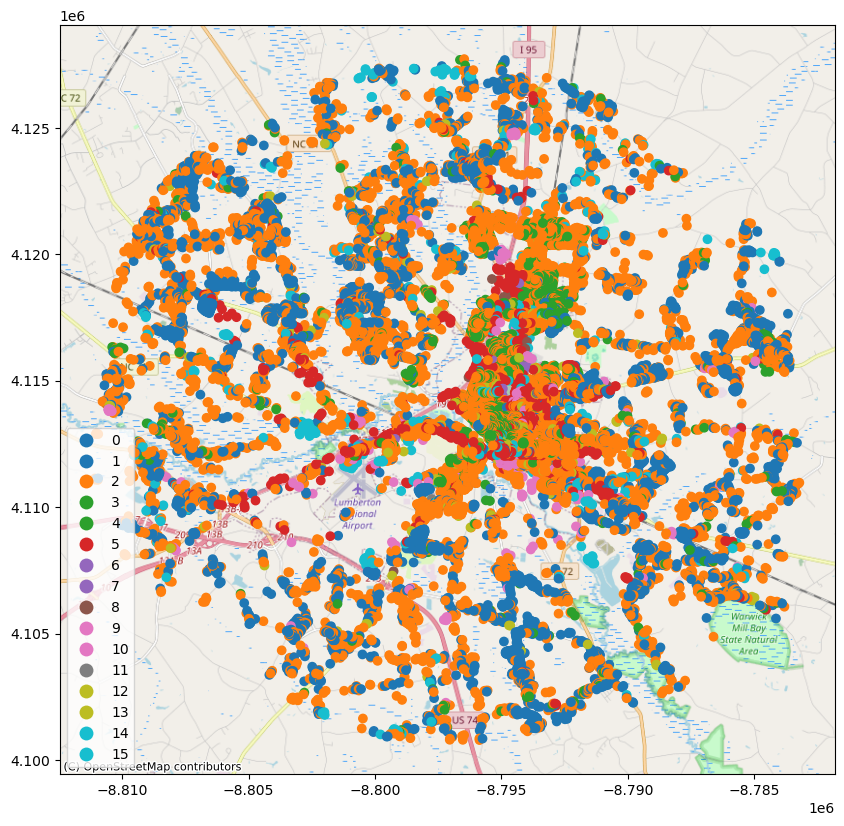

In [7]:
# Lumberton Building Inventory from IN-CORE
Building_Inventory_id = "6036c2a9e379f22e1658d451"

# visualize the building inventory
Lumberton_Building_Inventory = Dataset.from_data_service(Building_Inventory_id, DataService(client))
viz.plot_map(Lumberton_Building_Inventory, column="archetype", category=True, basemap=True)

In [8]:
# load building inventory as Geodataframe
filename = Lumberton_Building_Inventory.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)
bldg_inv_gdf = gpd.read_file(filename)
bldg_inv_gdf.head()

The IN-CORE Dataservice has saved the Building Inventory on your local machine: /Users/mohanar2/.incore/cache_data/648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737/6036c2a9e379f22e1658d451/lumberton_building_inventory_w_strcid/lumberton_building_inventory_w_strcid.shp


,guid,strctid,ffe_elev,archetype,parid,struct_typ,no_stories,a_stories,b_stories,bsmt_type,...,dwell_unit,str_typ2,occ_typ2,appr_bldg,appr_land,appr_tot,year_built,lhsm_elev,g_elev,geometry
0,efd13166-d7a0-476b-ada5-c55cea1f0184,STefd13166-d7a0-476b-ada5-c55cea1f0184,41.41049,1,3715514603,NaN,1,0,0,NaN,...,0,NaN,NaN,0,0,0,1988,0.0,40.2336,POINT (-79.08926 34.55354)
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,ST66352d95-70cb-46cb-8904-576f3ee3e9d3,43.86419,2,3715516008,NaN,1,0,0,NaN,...,0,NaN,NaN,0,0,0,1985,0.0,42.9768,POINT (-79.08488 34.56072)
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,STa4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,40.84585,2,3715514607,NaN,1,0,0,NaN,...,0,NaN,NaN,0,0,0,1988,0.0,39.9288,POINT (-79.08826 34.55475)
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,STe433891c-aa7a-47b0-a6aa-1b0895a65908,40.90913,2,3715514606,NaN,1,0,0,NaN,...,0,NaN,NaN,0,0,0,1988,0.0,39.9288,POINT (-79.08842 34.55446)
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,ST7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,40.69086,1,3715514605,NaN,1,0,0,NaN,...,0,NaN,NaN,0,0,0,1988,0.0,39.6240,POINT (-79.08862 34.55423)


### 2.3 Fragility-Based Vulnerability Modeling
A single-variable and multi-variate flood fragility and loss functions are developed for the 15 building archetypes. Each building archetype was divided into a set of components. For each component, the upper and lower bounds for the flood depth and flood duration that result in damage were used to develop 1000 normally distributed random samples for each component in between these bounds. Some of the upper and lower bounds for the components damaging flood depth and flood duration were collected from the literature and some of them were collected from online sources and others were assumed using the best engineering judgment. MCS was used to account for the components loss and failure probability for each component at each intensity measure (flood depth and flood duration) using the below equations:


![image2020-8-4_17-32-6.png](images/image2020-8-4_17-32-6.png)

where Frk(IM=x) = fragility function (failure probability at IM=x) for component k, D = component demand, R = component resistance, IM(x) is the intensity measure, nf = number of failed simulations, and N = the total number of simulations. Lk (IM=x) = is the component replacement cost vector at (IM=x), k = component number, Lrik = an i th random simulation of the replacement cost of component k, and Lik = an ith random simulation of the replacement cost for component k at a specified intensity measure (IM=x). µLk (IM=x) = the mean replacement cost of component k at (IM=x), and σLk (IM=x) = the standard deviation of the replacement cost of component k at (IM=x).



For buildings fragility functions, a set of performance criteria (damage states) for buildings subjected to flood hazards was developed. These performance criteria describe flood damage to buildings in terms of five damage states (DSs) ranging from insignificant damage (DS0) up to complete damage (DS4) as shown in Table (2). These DSs were designed such that they could describe both building functionality and serviceability in terms of the general building performance based on the behavior of a group of components exposed to a certain hazard intensity, thereby informing damage and the consequent level of occupancy. 

![sadfsa.png](images/sadfsa.png)

The exceedance probability of each DS was calculated based on the failure probability of each component within each DS and then weighted by the ratio of the replacement cost of each component to the replacement costs of all damageable components making up that DS using Eq. (5). Then, the calculated fragility was fitted using the lognormal cumulative distribution function (CDF) using Eq. (6). The below figure shows an example of how the exceedance probability of DS4 for a one-story residential building archetype (archetype F2) was derived from its components fragility with lognormal fitted fragility curves as solid lines.



![image2020-8-4_17-40-29.png](images/image2020-8-4_17-40-29.png)

where Lf(IM=x)  = total building fragility-based losses in monetary terms at IM=x (replacement or repair cost), P(DSi | IM=x) = exceedance probability of DSi at IM=x, P(DSi+1) = exceedance probability of DSi+1 at IM=x, Lrci = cumulative replacement cost ratio corresponding to DSi, and Vt = total building cost (replacement cost).



![image2020-8-4_17-47-40.png](images/image2020-8-4_17-47-40.png)

The lognormal parameters of the 2-D fragility functions are listed in Table (3). Additionally, the data for the 3-D fragility and loss functions are available in an excel format to be uploaded to the IN-CORE web services. It should be mentioned that DS0 only exists for archetypes with a crawlspace foundation which are archetypes F1 and F3. For all building archetypes, flood depth is measured from FFE. However, for the archetypes with crawl space foundation, flood depth is measured from ground elevation and the FFE is assumed to be at 1.0m from the ground elevation which explains why DS1 and DS2 for archetypes F1 and F3 are shifted from the suit of fragilities. Detailed results in terms of six figures for each building archetype (component fragility curves, total building fragility curves, selected components loss curves, total building loss curves, total building fragility surfaces, and total building loss surface) could be found in the references. The resulting fragility and loss functions including the 2-D and 3-D functions are organized into user-friendly matrices such that they can be easily used by researchers or be read by any algorithm to account for flood damage/loss at any intensity measure for any building archetype. 



![dsdfs-2.png](images/dsdfs-2.png)

The following code maps the fragility functions associated with each building archetype to the building inventory based on the assigned archetype to each building.

In [9]:
# Flood building archetypes mapping 
mapping_id = "602f3cf981bd2c09ad8f4f9d"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

### 2.4 Building Damage Analysis
Hazard, exposure, and vulnerability models were overlaid in a community-level loss/damage analysis framework that enables the flood loss/damage calculation for each building within the community using the framework illustrated in the flow chart in the below flow chart. This study represents the first time that a representative suite of flood fragilities have been utilized to perform community-level damage and loss analysis.



![image2020-8-4_21-15-8.png](images/image2020-8-4_21-15-8.png)

The following code sets up a buidling damage analysis with input datasets and parameters, then runs the analysis


In [10]:
bldg_dmg = BuildingDamage(client)

bldg_dmg.load_remote_input_dataset("buildings", Building_Inventory_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [11]:
# Run the building damage analysis
result_name = "Lumberton_bldg_flood_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Lumberton Flood Building Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)
bldg_dmg.run_analysis()

True

The following code explores the buildings damage analysis results

In [12]:
# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

In [13]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,efd13166-d7a0-476b-ada5-c55cea1f0184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


## 3. Housing Unit Allocation 
Housing Unit Allocation using Lumberton, North Carolina Housing Unit Inventory

Here we link high-resolution spatial data of all the households in Robeson County, NC and housing unit characteristics to residential buildings which is critical for linking socio-economic data within IN-CORE. 


The following code importing the pyincore function used for the Housing Unit Allocation Model

In [14]:
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

### 3.1 Initial Interdependent Community Description - Lumberton, NC

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation. The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

To run the HUA Algorithm, three input datasets are required:

1. Housing Unit Inventory - Based on 2010 US Census Block Level Data

2. Address Point Inventory - A list of all possible residential/business address points in a community. Address points are the link between buildings and housing units.

3. Building Inventory - A list of all buildings within a community.

In [15]:
# Lumberton, NC Housing unit inventory
housing_unit_inv = "60aac3195e52dd415f54e4ff"
# Lumberton, NC Address point inventory
address_point_inv = "60aac382088dfa3b65030b16"

### 3.2 Set Up and Run Housing Unit Allocation


In [16]:
# Create housing allocation
hua = HousingUnitAllocation(client)

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv)
hua.load_remote_input_dataset("buildings", Building_Inventory_id)

# Specify the result name
result_name = "Lumberton_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [17]:
# Run Housing unit allocation analysis
hua.run_analysis()

True

### 3.3  Explore results from Housing Unit Allocation

In [18]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','race','geometry']].head()

,guid,numprec,race,geometry
0,NaN,2.0,2.0,NaN
1,NaN,1.0,1.0,NaN
2,NaN,3.0,2.0,NaN
3,NaN,2.0,1.0,NaN
4,NaN,2.0,1.0,NaN


In [19]:
hua_df.columns

Index(['addrptid', 'strctid', 'ffe_elev', 'archetype', 'parid', 'struct_typ',
       'no_stories', 'a_stories', 'b_stories', 'bsmt_type', 'sq_foot',
       'gsq_foot', 'occ_type', 'occ_detail', 'major_occ', 'broad_occ',
       'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val',
       'efacility', 'dwell_unit', 'str_typ2', 'occ_typ2', 'appr_bldg',
       'appr_land', 'appr_tot', 'year_built', 'lhsm_elev', 'g_elev', 'blockid',
       'blockidstr', 'plcname10', 'plcgeoid10', 'countyfp10', 'huestimate',
       'residential', 'bldgobs', 'flag_ap', 'x', 'y', 'guid', 'randomap',
       'randommergeorder', 'huid', 'tractid', 'bgid', 'FIPScounty', 'serialno',
       'livetype', 'numprec', 'gqpop', 'ownershp', 'race', 'hispan',
       'hispan_flag', 'vacancy', 'gqtype', 'randomhu', 'aphumerge',
       'geometry'],
      dtype='object')

In [20]:
## Functions to add to pyincore-viz

def add_race_ethnicity_to_hua_df(df):

    df['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
    df['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

    df.loc[(df['race'] == 1) & (df['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
    df.loc[(df['race'] == 2) & (df['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
    df.loc[(df['race'] == 3) & (df['hispan'] == 0),'Race Ethnicity'] = "3 American Indian and Alaska Native alone, Not Hispanic"
    df.loc[(df['race'] == 4) & (df['hispan'] == 0),'Race Ethnicity'] = "4 Asian alone, Not Hispanic"
    df.loc[(df['race'].isin([5,6,7])) & (df['hispan'] == 0),'Race Ethnicity'] = "5 Other Race, Not Hispanic"
    df.loc[(df['hispan'] == 1),'Race Ethnicity'] = "6 Any Race, Hispanic"
    df.loc[(df['gqtype'] >= 1),'Race Ethnicity'] = "7 Group Quarters no Race Ethnicity Data"
    # Set Race Ethnicity to missing if structure is vacant - makes tables look nicer
    df.loc[(df['Race Ethnicity'] == "0 Vacant HU No Race Ethnicity Data"),'Race Ethnicity'] = np.nan

    return df

def add_tenure_to_hua_df(df):

    df['Tenure Status'] = "0 No Tenure Status"
    df['Tenure Status'].notes = "Identify Renter and Owner Occupied Housing Unit Characteristics."

    df.loc[(df['ownershp'] == 1),'Tenure Status'] = "1 Owner Occupied"
    df.loc[(df['ownershp'] == 2),'Tenure Status'] = "2 Renter Occupied"
    # Set Tenure Status to missing if structure is vacant - makes tables look nicer
    df.loc[(df['Tenure Status'] == "0 No Tenure Status"),'Tenure Status'] = np.nan

    return df

def add_dislocates_pd_df(df):
    """
    Population dislocation requires data on building damage and population charactersitics
    If the observation does not have building data then population dislocation 
    is set to missing.
    
    """
    df['Population Dislocation'] = "No Data"
    df['Population Dislocation'].notes = "Identify Population Dislocation."

    df.loc[(df['dislocated'] == False) & (df['guid'].notnull()),'Population Dislocation'] = "0 Does not dislocate"
    df.loc[(df['dislocated'] == True) & (df['guid'].notnull()),'Population Dislocation'] = "1 Dislocates"
    # Set Tenure Status to missing if structure is vacant - makes tables look nicer
    df.loc[(df['Population Dislocation'] == "No Data"),'Population Dislocation'] = np.nan

    return df

def add_colpercent(df, sourcevar, formatedvar):
    df['%'] = (df[sourcevar] / (df[sourcevar].sum()/2)* 100)
    df['(%)'] = df.agg('({0[%]:.1f}%)'.format,axis=1)
    df['value'] = df[sourcevar]
    df['format value'] =  df.agg('{0[value]:,.0f}'.format, axis=1)
    df[formatedvar]= df['format value'] + '\t '+ df['(%)']

    df = df.drop(columns=[sourcevar,'%','(%)','value','format value'])

    return df

# Draft function to add link to Census Data - preferable at the bottom of the table
def add_linktoCensusData(placeid = '1600000US3739700'):
    """
    I would like to have a source link under the table (left justified)
    It might be possible to edit the html code
    It might be possible to use display to "stack" 2 tables
    display(table1)
    display(source caption)
    """
    styles = [dict(selector="caption", 
    props=[("text-align", "left"),
           ("caption-side", "bottom"),
           ("font-size", "80%"),
           ("color", 'black')])]    # the color value can not be None

    url = 'https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P5&g='+placeid+'&tid=DECENNIALSF12010.P5'
    caption = "Validate results: <a href="+url+" target='_blank'> US Census Bureau Data Viewer </a>"

    output = df.style.set_table_attributes()\
     .set_caption(caption)\
     .set_table_styles(styles)

    
    return output

def pop_results_table(df, 
                      who = "Total Houseohlds", 
                      what= "by Race, Ethncity, and Tenure Status",
                      when = "2010", 
                      where = "",
                      row_index = 'Race Ethnicity',
                      col_index = 'Tenure Status',
                      row_percent = ''):
    
    df = add_race_ethnicity_to_hua_df(df)
    df = add_tenure_to_hua_df(df)
    
    if who == "Total Houseohlds":
        variable = 'numprec'
        function = 'count'
        renamecol = {'Total': who, 'sum': ''}
        num_format = "{:,.0f}"
    elif who == "Total Population":
        variable = 'numprec'
        function = 'sum'
        renamecol = {'Total': who, 'sum': ''}
        num_format = "{:,.0f}"
    elif who == "Median Household Income":
        variable = 'randincome'
        function = np.median
        renamecol = {'Total': who}
        num_format = "${:,.0f}"
    else:
        variable = 'numprec'
        function = 'count'
        renamecol = {'Total': who, 'sum': ''}
        num_format = "{:,.0f}"
        
    # Generate table
    table = pd.pivot_table(df, values=variable, index=[row_index],
                           margins = True, margins_name = 'Total',
                           columns=[col_index], aggfunc=function).rename(columns=renamecol)
    table_title = "Table. "+ who +" "+ what+", "+ where +", "+ when +"."
    varformat = {(who): num_format}
    for col in table.columns:
        varformat[col] = num_format
        
    # Add percent row column
    if row_percent != '':
        numerator = table[row_percent]
        denomenator = table[who]
        table['row_pct'] = numerator/denomenator * 100
        table['Percent Row ' + '\n' + row_percent] = table.agg('{0[row_pct]:.1f}%'.format,axis=1)
        table = table.drop(columns=['row_pct'])
    
    # Add Column Percents 
    if who in ["Total Houseohlds","Total Population"]:
        # add column percent to all columns except the percent row column
        row_pct_vars = [col for col in table if col.startswith('Percent Row ')]
        columns = [col for col in table if col not in row_pct_vars]
        for col in columns:
            formated_column_name = col + ' (%)'
            table = add_colpercent(table, col, formated_column_name)
            
    # Move row percent to last column
    if row_percent != '':
        row_pct_vars = [col for col in table if col.startswith('Percent Row ')]
        columns = [col for col in table if col not in row_pct_vars]
        table = table[columns + row_pct_vars]
        
    # To do - add source information (inlcude Census Link with Place ID)
    # To do - add provenance option - name of dataset ource and program name
        
    # Caption Title Style
    styles = [dict(selector="caption", 
        props=[("text-align", "center"),
               ("caption-side", "top"),
               ("font-size", "150%"),
               ("color", 'black')])]    # the color value can not be None
    
    table = table.style\
     .set_caption(table_title)\
     .set_table_styles(styles)\
     .format(varformat)

    return table

In [21]:
pop_results_table(hua_df, where = "Robeson County NC")

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Houseohlds (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","11,154 (36.1%)","4,222 (26.4%)","15,376 (32.8%)"
"2 Black alone, Not Hispanic","5,891 (19.1%)","5,227 (32.7%)","11,118 (23.7%)"
"3 American Indian and Alaska Native alone, Not Hispanic","12,561 (40.7%)","4,719 (29.5%)","17,280 (36.9%)"
"4 Asian alone, Not Hispanic",114 (0.4%),144 (0.9%),258 (0.6%)
"5 Other Race, Not Hispanic",292 (0.9%),268 (1.7%),560 (1.2%)
"6 Any Race, Hispanic",859 (2.8%),"1,410 (8.8%)","2,269 (4.8%)"
Total,"30,871 (100.0%)","15,990 (100.0%)","46,861 (100.0%)"


In [22]:
pop_results_table(hua_df, 
                  who = "Total Population", 
                  where = "Robeson County NC")

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","26,713 (32.1%)","9,641 (22.6%)","36,354 (28.8%)"
"2 Black alone, Not Hispanic","15,536 (18.7%)","13,899 (32.5%)","29,435 (23.4%)"
"3 American Indian and Alaska Native alone, Not Hispanic","36,196 (43.5%)","12,424 (29.1%)","48,620 (38.6%)"
"4 Asian alone, Not Hispanic",366 (0.4%),497 (1.2%),863 (0.7%)
"5 Other Race, Not Hispanic",870 (1.0%),717 (1.7%),"1,587 (1.3%)"
"6 Any Race, Hispanic","3,607 (4.3%)","5,565 (13.0%)","9,172 (7.3%)"
Total,"83,288 (100.0%)","42,743 (100.0%)","126,031 (100.0%)"


In [23]:
pop_results_table(hua_df.loc[hua_df['plcname10']=='Lumberton'].copy(), 
                  who = "Total Population", 
                  what = "by Race, Ethncity, and Building Data",
                  where = "Lumberton NC")

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","5,599 (61.4%)","2,474 (25.4%)","8,073 (42.8%)"
"2 Black alone, Not Hispanic","2,052 (22.5%)","4,699 (48.2%)","6,751 (35.8%)"
"3 American Indian and Alaska Native alone, Not Hispanic",951 (10.4%),"1,366 (14.0%)","2,317 (12.3%)"
"4 Asian alone, Not Hispanic",214 (2.3%),275 (2.8%),489 (2.6%)
"5 Other Race, Not Hispanic",105 (1.2%),209 (2.1%),314 (1.7%)
"6 Any Race, Hispanic",201 (2.2%),727 (7.5%),928 (4.9%)
Total,"9,122 (100.0%)","9,750 (100.0%)","18,872 (100.0%)"


### 3.4 Validate the Housing Unit Allocation has worked

Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census. This can be confirmed by going to data.census.gov

https://data.census.gov/cedsci/table?q=DECENNIALPL2010.H11&g=1600000US3739700&tid=DECENNIALSF12010.H11

Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building dresults will become the input for the dislocation model.

In [24]:
# Save cleaned HUA file as CSV
hua_df.to_csv(result_name + str(seed) + '_cleaned.csv')

In [25]:
# example of buildings that are exposed to flood hazard
hua_df[['guid','x','y','race','geometry']][21400:21406]

,guid,x,y,race,geometry
21400,efb34d88-a561-4171-b072-5e46b90ff11d,-79.06763,34.71275,3.0,POINT (-79.06762524210063 34.712750348024464)
21401,9ceedf40-bd49-415f-96da-ee8f1ab1a76a,-79.07293,34.72168,1.0,POINT (-79.072928185158 34.72167536346757)
21402,c65bccde-436e-4167-8d5f-a34f562683d5,-79.06914,34.71069,3.0,POINT (-79.0691395688385 34.71069077912331)
21403,1c2676fa-770d-4062-8f57-fb112f41df11,-79.06868,34.71410,1.0,POINT (-79.06868325871137 34.714100384003125)
21404,0bf861ba-418e-4311-b168-0801c2e469f4,-79.07134,34.72546,3.0,POINT (-79.07134033586827 34.72546264294466)
21405,380a7e22-c5b6-4d08-b093-f85142b83d5c,-79.06767,34.71007,1.0,POINT (-79.0676706857598 34.71006925711998)


In [26]:
# example of buildings outside the floodplain
hua_df[['guid','x','y','race','geometry']].head(6)

,guid,x,y,race,geometry
0,NaN,-78.94752,34.90556,2.0,NaN
1,NaN,-78.95882,34.89573,1.0,NaN
2,NaN,-78.95882,34.89573,2.0,NaN
3,NaN,-78.95882,34.89573,1.0,NaN
4,NaN,-78.96133,34.88307,1.0,NaN
5,NaN,-78.96133,34.88307,1.0,NaN


In [27]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
hua_gdf = gpd.GeoDataFrame(
    hua_df,
    crs=('epsg:4326'),
    geometry=[Point(xy) for xy in zip(hua_df['x'], hua_df['y'])])
hua_gdf[['guid','x','y','race','geometry']][21400:21406]

,guid,x,y,race,geometry
21400,efb34d88-a561-4171-b072-5e46b90ff11d,-79.06763,34.71275,3.0,POINT (-79.06763 34.71275)
21401,9ceedf40-bd49-415f-96da-ee8f1ab1a76a,-79.07293,34.72168,1.0,POINT (-79.07293 34.72168)
21402,c65bccde-436e-4167-8d5f-a34f562683d5,-79.06914,34.71069,3.0,POINT (-79.06914 34.71069)
21403,1c2676fa-770d-4062-8f57-fb112f41df11,-79.06868,34.71410,1.0,POINT (-79.06868 34.71410)
21404,0bf861ba-418e-4311-b168-0801c2e469f4,-79.07134,34.72546,3.0,POINT (-79.07134 34.72546)
21405,380a7e22-c5b6-4d08-b093-f85142b83d5c,-79.06767,34.71007,1.0,POINT (-79.06767 34.71007)


### 3.5 Visualize heat map

In [28]:
map = viz.plot_heatmap_from_gdf(hua_gdf, "numprec", radius=7, blur=10, name="HUA Heatmap")
map

Map(center=[34.646235000000004, -79.141885], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## 4. Population Dislocation Analysis
Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

## 4.1 Set Up and Run Population Dislocation

In [29]:
from pyincore.analyses.populationdislocation import PopulationDislocation

### Use new pyincore-data utility to obtain Block Group Data for County

In [30]:
from pyincore_data.censusutil import CensusUtil

In [31]:
state_counties = ['37155']
blockgroup_df, bgmap, outdataset = CensusUtil.get_blockgroupdata_for_dislocation(state_counties, 
                                                                 out_csv=True, 
                                                                 out_shapefile=False, 
                                                                 out_html=False)

INFO - censusutil.py:get_blockgroupdata_for_dislocation() - Census API data from: https://api.census.gov/data/2010/dec/sf1?get=GEO_ID,NAME,P005001,P005003,P005004,P005010&for=block%20group&in=state:37&in=county:155


880
P005001 converted from object to integer
P005003 converted from object to integer
P005004 converted from object to integer
P005010 converted from object to integer
CSV data file saved to: program_name/program_name_geo_name.csv
Shapefile data file saved to: program_name/program_name_geo_name.shp


In [32]:
blockgroup_df.head()

,bgid,bgidstr,Survey,pblackbg,phispbg
0,371559601011,BG371559601011,2010 dec/sf1,25.417323,25.007874
1,371559601012,BG371559601012,2010 dec/sf1,25.578947,22.526316
2,371559601021,BG371559601021,2010 dec/sf1,18.522484,9.314775
3,371559601022,BG371559601022,2010 dec/sf1,48.181818,10.090909
4,371559601023,BG371559601023,2010 dec/sf1,14.238953,34.206219


In [33]:
# Lumberton, NC Block group data, IN-CORE_BGMAP_2021-01-19_Lumberton NC
# bg_data = "60b18cb04bed6e6c318b1c9b" # pyincore-data has created the required dataset locally
# Seaside, OR Housing unit allocation, performed at start of notebook
bg_data = Dataset.from_file('program_name/program_name_geo_name.csv','incore:blockGroupData')

# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

In [34]:
pop_dis = PopulationDislocation(client)

In [35]:
pop_dis.set_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

True

In [36]:
result_name = "Lumberton-pop-disl-results"
seed = 1111

In [37]:
pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

True

In [38]:
pop_dis.run_analysis()

/Users/mohanar2/anaconda3/envs/incore-docs/lib/python3.9/site-packages/pyincore/analyses/populationdislocation/populationdislocation.py:169: RuntimeWarning: invalid value encountered in cast
  hue = inventory["huestimate"].values.astype(int)


True

In [39]:
# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = result.get_dataframe_from_csv(low_memory=False)

# Display last 5 rows of output data
pd_df.tail()

,guid,DS_0,DS_1,DS_2,DS_3,haz_expose,addrptid,strctid,ffe_elev,archetype,...,Survey,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated
61500,a5615477-64da-4953-9fb7-d5ce5f575a3c,1.0,0.0,0.0,0.0,no,STa5615477-64da-4953-9fb7-d5ce5f575a3cAP000001,STa5615477-64da-4953-9fb7-d5ce5f575a3c,43.12627,1.0,...,NaN,NaN,NaN,0,0.003300,0.108449,0.660077,0.944031,NaN,False
61501,43a5fe43-22a4-44fe-8d3f-0510015fb123,1.0,0.0,0.0,0.0,no,ST43a5fe43-22a4-44fe-8d3f-0510015fb123AP000001,ST43a5fe43-22a4-44fe-8d3f-0510015fb123,42.58784,2.0,...,NaN,NaN,NaN,0,0.004819,0.104080,0.547637,0.899055,NaN,False
61502,18675117-7501-47e6-8468-821ea423f004,1.0,0.0,0.0,0.0,no,ST18675117-7501-47e6-8468-821ea423f004AP000001,ST18675117-7501-47e6-8468-821ea423f004,42.89920,1.0,...,NaN,NaN,NaN,0,0.008700,0.100391,0.604453,0.921781,NaN,False
61503,a5615477-64da-4953-9fb7-d5ce5f575a3c,1.0,0.0,0.0,0.0,no,STa5615477-64da-4953-9fb7-d5ce5f575a3cAP000000,STa5615477-64da-4953-9fb7-d5ce5f575a3c,43.12627,1.0,...,NaN,NaN,NaN,0,0.005772,0.147216,0.367531,0.827012,NaN,False
61504,edf491be-d131-4409-b6d3-db5ffbdb52e3,1.0,0.0,0.0,0.0,no,STedf491be-d131-4409-b6d3-db5ffbdb52e3AP000000,STedf491be-d131-4409-b6d3-db5ffbdb52e3,42.25433,2.0,...,NaN,NaN,NaN,0,0.002954,0.105273,0.589054,0.915622,NaN,False


## 4.2 Explore Population Dislocation Results by Schools

In [40]:
# Data file id
dataset_id = "60e5edd3d3c92a78c8940d06"
# load building inventory
dataset = Dataset.from_data_service(dataset_id, data_service)
filename = dataset.get_file_path('csv')
metadata = data_service.get_dataset_metadata(dataset_id = dataset_id)
print("The IN-CORE Dataservice has saved the dataset titled: "+metadata['title']+" on your local machine: "+filename)
print("\nDataset Description: \n"+metadata['description'])

The IN-CORE Dataservice has saved the dataset titled: Robeson County, NC Census Blocks and School Attendance Boundaries on your local machine: /Users/mohanar2/.incore/cache_data/648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737/60e5edd3d3c92a78c8940d06/IN-CORE_1hv1_AddSABS_BlockData_2021-07-01/IN-CORE_1hv1_AddSABS_BlockData_2021-07-01.csv

Dataset Description: 
2010 Census Blocks matched to 2015-2016 NCES School Attendance Boundaries. 2010 Census Block ID: BLOCKID10Primary schools (ncessch_1: NCESid, primary_schnm: Primary School Name) Middle schools (ncessch_2: NCESid, mid_schnm: Middle School Name) High schools (ncessch_3: NCESid, high_schnm: High School Name) Unique ids are primary and foreign keys to link to Housing Unit Inventory and School Characteristics.


In [41]:
sabs_df = pd.read_csv(filename)
sabs_df.head()

,BLOCKID10,ncessch_3,high_schnm,ncessch_2,mid_schnm,ncessch_1,primary_schnm
0,371559619002028,370393002184,South Robeson High,3.703930e+11,Fairgrove Middle,370393001571,Green Grove Elementary
1,371559619002054,370393002232,Fairmont High,3.703930e+11,Fairmont Middle,370393002241,Rosenwald Elementary
2,371559617002069,370393002232,Fairmont High,3.703930e+11,Fairmont Middle,370393002241,Rosenwald Elementary
3,371559617002065,370393002232,Fairmont High,3.703930e+11,Fairmont Middle,370393002241,Rosenwald Elementary
4,371559617002058,370393002232,Fairmont High,3.703930e+11,Fairmont Middle,370393002241,Rosenwald Elementary


In [42]:
pd_df = pd.merge(pd_df, sabs_df, 
                        left_on='blockid', right_on='BLOCKID10', how='left')
pd_df[['blockid','huid','ncessch_3','high_schnm','ncessch_2','mid_schnm','ncessch_1','primary_schnm']].head()

,blockid,huid,ncessch_3,high_schnm,ncessch_2,mid_schnm,ncessch_1,primary_schnm
0,371559601011002,H371559601011002001,370393002244,Saint Pauls High,NaN,No Middle School SAB,370393001577,Parkton Elementary
1,371559601011003,H371559601011003001,370393002244,Saint Pauls High,NaN,No Middle School SAB,370393001577,Parkton Elementary
2,371559601011003,H371559601011003003,370393002244,Saint Pauls High,NaN,No Middle School SAB,370393001577,Parkton Elementary
3,371559601011003,H371559601011003002,370393002244,Saint Pauls High,NaN,No Middle School SAB,370393001577,Parkton Elementary
4,371559601011005,H371559601011005003,370393002244,Saint Pauls High,NaN,No Middle School SAB,370393001577,Parkton Elementary


In [43]:
pd_df = add_dislocates_pd_df(pd_df)

In [44]:
pop_results_table(pd_df.loc[pd_df['mid_schnm']=='Lumberton Junior High'].copy(), 
                  who = "Total Population", 
                  what = "by Primary School Name, and Population Dislocation Data",
                  where = "Lumberton Junior High NC",
                  row_index = 'primary_schnm',
                  col_index = 'Population Dislocation',
                  row_percent = "1 Dislocates")

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population (%),Percent Row 1 Dislocates
primary_schnm,,,,
Janie C Hargrave Elem,"3,191 (15.0%)",90 (9.2%),"3,281 (14.8%)",2.7%
Rowland Norment Elementary,"6,571 (31.0%)",nan (nan%),"6,571 (29.6%)",nan%
Tanglewood Elementary,"7,953 (37.5%)",3 (0.3%),"7,956 (35.9%)",0.0%
W H Knuckles,"2,513 (11.8%)",636 (65.2%),"3,149 (14.2%)",20.2%
West Lumberton Elementary,985 (4.6%),247 (25.3%),"1,232 (5.6%)",20.0%
Total,"21,213 (100.0%)",976 (100.0%),"22,189 (100.0%)",4.4%
